### MFIN7034 Problem Set 2 – Risk Analysis

In [1]:
import os

data_path = "data"
if os.path.exists(data_path):
    os.chdir(data_path)
    print("current working directory: ", os.getcwd())
else:
    print("invalid data address")

current working directory:  /Users/Mike_Home/Desktop/MFIN7034 Machine Learning and Artificial Intelligence in Finance/HKU-MFIN7034-ML/data


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
credit_risk_df = pd.read_csv("credit_risk.csv")
credit_risk_df.head()

,default_label,age,gender,edu,housing,income,job_occupation,past_bad_credit,married
0,0,45,0,2,0,8756.330191,0,1,1
1,0,33,1,1,1,4762.472193,1,1,0
2,0,21,0,3,0,10944.838300,0,1,0
3,0,64,0,2,1,3957.592804,2,1,1
4,0,33,0,3,1,17820.791010,1,1,0


In [4]:
defualt_rate = len(credit_risk_df[credit_risk_df["default_label"] == 1]) / len(credit_risk_df) * 100
print(f"The default rate is {defualt_rate:.3f}%")

The default rate is 2.216%


In [5]:
credit_risk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14262 entries, 0 to 14261
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   default_label    14262 non-null  int64  
 1   age              14262 non-null  int64  
 2   gender           14262 non-null  int64  
 3   edu              14262 non-null  int64  
 4   housing          14262 non-null  int64  
 5   income           14255 non-null  float64
 6   job_occupation   14262 non-null  int64  
 7   past_bad_credit  14262 non-null  int64  
 8   married          14262 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 1002.9 KB


In [6]:
credit_risk_df.describe()

,default_label,age,gender,edu,housing,income,job_occupation,past_bad_credit,married
count,14262.000000,14262.000000,14262.000000,14262.000000,14262.000000,1.425500e+04,14262.000000,14262.000000,14262.000000
mean,0.022157,46.566540,0.458701,1.695905,0.625789,1.233044e+04,0.336068,0.964591,0.525522
std,0.147198,221.030605,0.498309,1.101667,0.483936,2.214739e+05,0.557614,0.184817,0.499366
min,0.000000,17.000000,0.000000,0.000000,0.000000,6.504225e+02,0.000000,0.000000,0.000000
25%,0.000000,29.000000,0.000000,1.000000,0.000000,2.413715e+03,0.000000,1.000000,0.000000
50%,0.000000,42.000000,0.000000,2.000000,1.000000,5.565963e+03,0.000000,1.000000,1.000000
75%,0.000000,54.000000,1.000000,2.000000,1.000000,1.059000e+04,1.000000,1.000000,1.000000
max,1.000000,9999.000000,1.000000,4.000000,1.000000,9.999999e+06,2.000000,1.000000,1.000000


In [7]:
print(credit_risk_df.isnull().sum())
# drop na values
credit_risk_df.dropna(inplace=True)

default_label      0
age                0
gender             0
edu                0
housing            0
income             7
job_occupation     0
past_bad_credit    0
married            0
dtype: int64


#### 1.1 Logistic Model

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

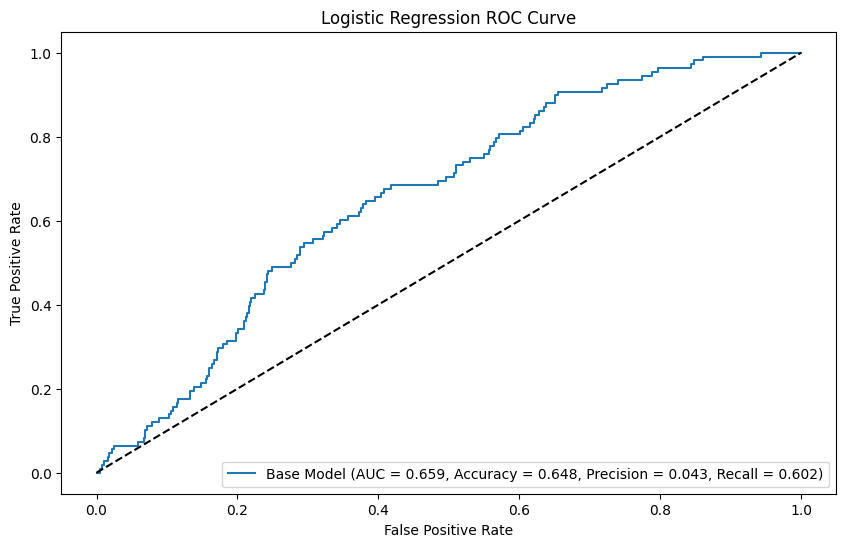

In [9]:
# define the feature columns and target column
def run_logistic_regression(features_df, target_series, model_name="", max_iter=1000, plot=True):
    X_train, X_test, y_train, y_test = train_test_split(
        features_df, target_series, test_size=0.3, random_state=42
    )
    
    # add class weight parameter to handle imbalance
    log_reg = LogisticRegression(class_weight="balanced", max_iter=max_iter)
    log_reg.fit(X_train, y_train)
    
    # get predicted probabilities for ROC curve
    y_proba = log_reg.predict_proba(X_test)[:, 1]
    
    # calculate evaluation metrics
    fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)
    auc_score = metrics.roc_auc_score(y_test, y_proba)

    # get predicted labels
    y_pred = log_reg.predict(X_test)
    # calculate precision and recall
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    # calculate accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)

    if plot:
        # run and compare models
        plt.figure(figsize=(10, 6))
        # plot ROC curve
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.3f}, Accuracy = {accuracy:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Logistic Regression ROC Curve")
        plt.legend(loc="lower right")
        plt.show()

    return (fpr, tpr, auc_score, accuracy, precision, recall)

# original features
base_features = ["age", "gender", "edu", "housing", "income", 
                "job_occupation", "past_bad_credit", "married"]

_ = run_logistic_regression(
    credit_risk_df[base_features],
    credit_risk_df["default_label"],
    model_name="Base Model"
)

In [10]:
# add more interaction term variables and non-linear transformation variables
credit_risk_transformed_df = credit_risk_df.copy()
credit_risk_transformed_df["age_squared"] = credit_risk_transformed_df["age"] ** 2
credit_risk_transformed_df["age_sqrt"] = np.sqrt(credit_risk_transformed_df["age"])
credit_risk_transformed_df["age_log"] = np.log(credit_risk_transformed_df["age"])

credit_risk_transformed_df["income_squared"] = credit_risk_transformed_df["income"] ** 2
credit_risk_transformed_df["income_sqrt"] = np.sqrt(credit_risk_transformed_df["income"])
credit_risk_transformed_df["income_log"] = np.log(credit_risk_transformed_df["income"])

credit_risk_transformed_df["housing_squared"] = credit_risk_transformed_df["housing"] ** 2
credit_risk_transformed_df["edu_squared"] = credit_risk_transformed_df["edu"] ** 2
credit_risk_transformed_df["job_occupation_squared"] = credit_risk_transformed_df["job_occupation"] ** 2

credit_risk_transformed_df["age_income_interaction"] = credit_risk_transformed_df["age"] * credit_risk_transformed_df["income"]
credit_risk_transformed_df["edu_income_interaction"] = credit_risk_transformed_df["edu"] * credit_risk_transformed_df["income"]
credit_risk_transformed_df["age_edu_interaction"] = credit_risk_transformed_df["age"] * credit_risk_transformed_df["edu"]

+-----------------------------+-------+------------+-------------+----------+------------+
|            Model            |   AUC |   Accuracy |   Precision |   Recall |   F1-Score |
+=============================+=======+============+=============+==========+============+
|        Base Features        | 0.659 |      0.648 |       0.043 |    0.602 |      0.079 |
+-----------------------------+-------+------------+-------------+----------+------------+
| Adding Interaction Features | 0.629 |      0.591 |       0.036 |    0.593 |      0.068 |
+-----------------------------+-------+------------+-------------+----------+------------+
|  Adding Nonlinear Features  | 0.7   |      0.621 |       0.043 |    0.657 |      0.081 |
+-----------------------------+-------+------------+-------------+----------+------------+
|     Adding All Features     | 0.702 |      0.622 |       0.044 |    0.667 |      0.082 |
+-----------------------------+-------+------------+-------------+----------+------------+

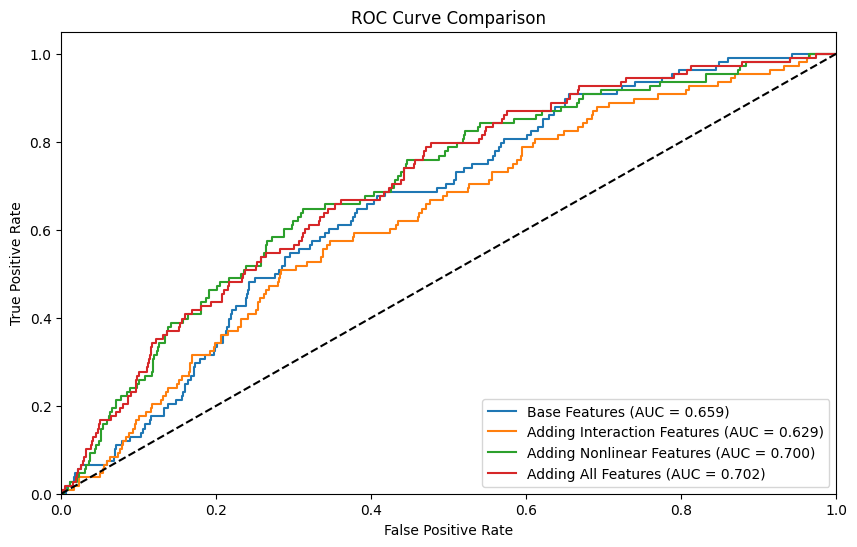

In [14]:
from tabulate import tabulate

interaction_features = [
    "age_income_interaction",
    "edu_income_interaction",
    "age_edu_interaction",
]

nonlinear_features = [
    "age_sqrt",
    "income_sqrt",
    "housing_squared",
    "edu_squared",
    "job_occupation_squared"
]

# plot ROC curve for different feature combinations
plt.figure(figsize=(10, 6))
results = {}

for features, name in [
    (base_features, "Base Features"),
    (base_features + interaction_features, "Adding Interaction Features"),
    (base_features + nonlinear_features, "Adding Nonlinear Features"),
    (base_features + interaction_features + nonlinear_features, "Adding All Features")
]:
    fpr, tpr, auc_score, accuracy, precision, recall = run_logistic_regression(
        credit_risk_transformed_df[features],
        credit_risk_transformed_df["default_label"],
        model_name=name,
        plot=False
    )
    
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")
    
    f1 = 2 * precision * recall / (precision + recall)

    results[name] = {
        "AUC": auc_score,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

# pretty print
table_data = [
    [name,
     f"{metrics['AUC']:.3f}",
     f"{metrics['Accuracy']:.3f}",
     f"{metrics['Precision']:.3f}",
     f"{metrics['Recall']:.3f}",
     f"{metrics['F1-Score']:.3f}"]
    for name, metrics in results.items()
]

print(tabulate(
    table_data,
    headers=["Model", "AUC", "Accuracy", "Precision", "Recall", "F1-Score"],
    tablefmt="grid",
    stralign="center"
))

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()

##### Find best combo of additional features though loops:

In [15]:
from itertools import combinations

feature_sets = [base_features]

interaction_feature_subsets = []
for r in range(1, len(interaction_features) + 1):
    for combo in combinations(interaction_features, r):
        for age_feature in ["age_squared", "age_sqrt", "age_log"]:
            for income_feature in ["income_squared", "income_sqrt", "income_log"]:
                feature_sets.append(base_features + [age_feature, income_feature] + list(combo))

print(f"Number of combinations: {len(feature_sets)}")
# check if each element in feature_sets is unique
if len(feature_sets) == len(set(tuple(fs) for fs in feature_sets)):
    print("All feature sets are unique.")
else:
    print("There are duplicate feature sets.")


Number of combinations: 64
All feature sets are unique.


In [20]:
from tqdm import tqdm
from pprint import pprint

best_auc = 0
for feature_set in tqdm(feature_sets):
    _, _, curr_auc, _, _, _ = run_logistic_regression(
        credit_risk_transformed_df[feature_set],
        credit_risk_transformed_df["default_label"],
        model_name=f"Feature Set {feature_set}",
        plot=False
    )

    if curr_auc > best_auc:
        best_auc = curr_auc
        best_feature_set = feature_set

print(f"Best AUC: {best_auc:.3f}")
pprint(f"Best Feature Set: {best_feature_set}")

100%|██████████| 64/64 [00:25<00:00,  2.47it/s]

Best AUC: 0.706
("Best Feature Set: ['age', 'gender', 'edu', 'housing', 'income', "
 "'job_occupation', 'past_bad_credit', 'married', 'age_squared', "
 "'income_sqrt', 'age_income_interaction', 'age_edu_interaction']")


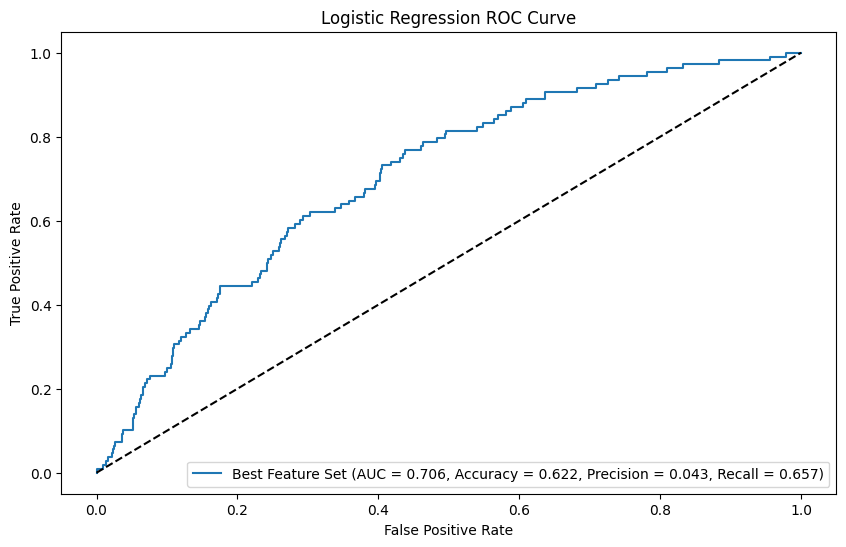

In [21]:
_ = run_logistic_regression(
    credit_risk_transformed_df[best_feature_set],
    credit_risk_transformed_df["default_label"],
    model_name="Best Feature Set"
)

#### 1.2.2 Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc

def run_random_forest(features_df, target_series, model_name="", plot=True):
    # use same train/test split for fair comparison
    X_train, X_test, y_train, y_test = train_test_split(
        features_df, target_series, test_size=0.3, random_state=42, stratify=target_series
    )
    
    # parameter grid for randomized search
    param_grid = {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10],
        "max_features": ["sqrt", "log2", 0.5],
        "class_weight": ["balanced", "balanced_subsample"],
        "bootstrap": [True, False],
        "oob_score": [True],
        "min_samples_leaf": [1, 2, 4],
        "max_samples": [0.6, 0.8, None],
        "max_leaf_nodes": [None, 50, 100],
        "ccp_alpha": [0.0, 0.01, 0.1]
    }
    
    # initialize and tune RF model
    rf = RandomForestClassifier(random_state=42)
    search = RandomizedSearchCV(
        rf, param_grid, n_iter=30, scoring="roc_auc", 
        n_jobs=-1, cv=5, random_state=42
    )
    search.fit(X_train, y_train)
    
    # get best model
    best_rf = search.best_estimator_
    
    # get predictions and probabilities
    y_pred = best_rf.predict(X_test)
    y_proba = best_rf.predict_proba(X_test)[:, 1]
    
    # calculate metrics
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1_score = 2 * precision * recall / (precision + recall)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = auc(fpr, tpr)
    feature_importances = best_rf.feature_importances_
    
    if plot:
        # plot ROC curve
        plt.figure(figsize=(10, 6))
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.3f}, Accuracy = {accuracy:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}, F1-Score = {f1_score:.3f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Random Forest ROC Curve")
        plt.legend(loc="lower right")
        plt.show()
        
        # plot feature importances
        sorted_idx = feature_importances.argsort()[::-1]
        plt.figure(figsize=(10, 6))
        plt.bar(range(X_train.shape[1]), feature_importances[sorted_idx], align="center")
        plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_idx], rotation=90)
        plt.xlabel("features")
        plt.ylabel("importance")
        plt.title("feature importance ranking")
        plt.tight_layout()
        plt.show()

    return best_rf

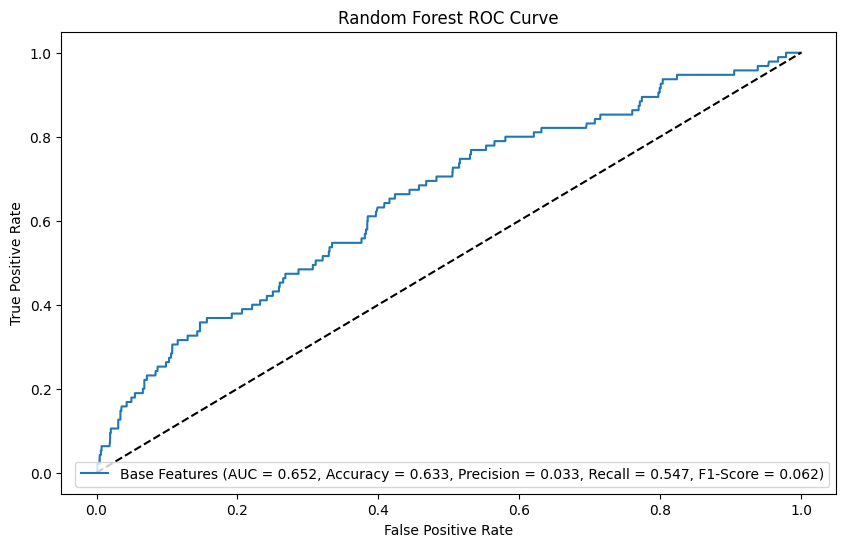

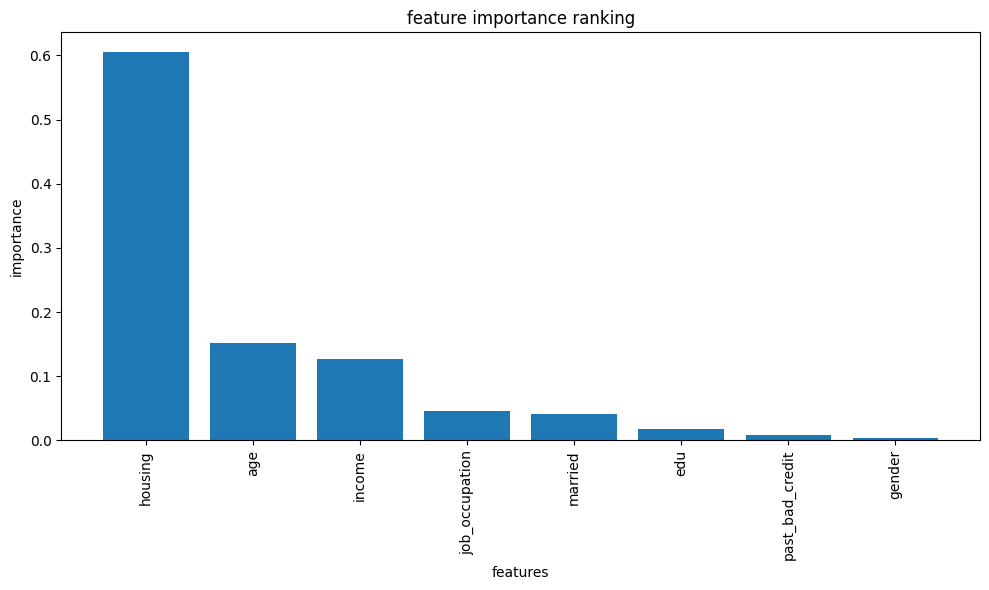

In [45]:
# run random forest with base features
best_rf = run_random_forest(
    credit_risk_df.drop("default_label", axis=1),
    credit_risk_df["default_label"],
    model_name="Base Features"
)

In [48]:
# print model parameters
from tabulate import tabulate

params = best_rf.get_params()
params_df = pd.DataFrame(list(params.items()), columns=["Parameter", "Value"])

print("Model Parameters:")
print(tabulate(params_df, headers="keys", tablefmt="grid", showindex=False))

Model Parameters:
+--------------------------+----------+
| Parameter                | Value    |
+==========================+==========+
| bootstrap                | True     |
+--------------------------+----------+
| ccp_alpha                | 0.01     |
+--------------------------+----------+
| class_weight             | balanced |
+--------------------------+----------+
| criterion                | gini     |
+--------------------------+----------+
| max_depth                | 20       |
+--------------------------+----------+
| max_features             | log2     |
+--------------------------+----------+
| max_leaf_nodes           | 100      |
+--------------------------+----------+
| max_samples              | 0.8      |
+--------------------------+----------+
| min_impurity_decrease    | 0.0      |
+--------------------------+----------+
| min_samples_leaf         | 1        |
+--------------------------+----------+
| min_samples_split        | 2        |
+---------------------

In [59]:
# pretty print feature importance
importances = best_rf.feature_importances_
sorted_idx = importances.argsort()[::-1]

importance_df = pd.DataFrame({
    "Feature": credit_risk_df.drop("default_label", axis=1).columns[sorted_idx],
    "Importance": importances[sorted_idx]
})

print(tabulate(
    importance_df,
    headers="keys",
    tablefmt="grid",
    showindex=False
))

+-----------------+--------------+
| Feature         |   Importance |
+=================+==============+
| housing         |   0.605593   |
+-----------------+--------------+
| age             |   0.150963   |
+-----------------+--------------+
| income          |   0.127342   |
+-----------------+--------------+
| job_occupation  |   0.0457172  |
+-----------------+--------------+
| married         |   0.0412001  |
+-----------------+--------------+
| edu             |   0.0179562  |
+-----------------+--------------+
| past_bad_credit |   0.00828422 |
+-----------------+--------------+
| gender          |   0.00294337 |
+-----------------+--------------+


#### 1.3 LightGBM

In [60]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

def run_lightgbm(features_df, target_series, model_name="", plot=True):

    # Handle class imbalance
    default_ratio = (len(target_series) - target_series.sum()) / target_series.sum()
    lgb_params = {
        'scale_pos_weight': default_ratio,  # critical for credit defaults
        'class_weight': 'balanced'
    }
    
    # split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        features_df, target_series, 
        test_size=0.3, 
        random_state=42, 
        stratify=target_series
    )
    
    # base parameters
    params = {
        "objective": "binary",
        "metric": "auc",
        "boosting_type": "gbdt",
        "verbosity": -1,
        "random_state": 42,
        "class_weight": "balanced",
        "deterministic": True,
        "max_cat_threshold": 32,
        "min_gain_to_split": 0.01
    }
    
    # hyperparameter search space
    param_grid = {
        "num_leaves": [15, 31, 63, 127],  # expanded range
        "learning_rate": [0.005, 0.01, 0.05, 0.1],  # added lower rate
        "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],  # finer granularity
        "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
        "reg_alpha": [0, 0.01, 0.1, 1, 10],  # L1 range
        "reg_lambda": [0, 0.01, 0.1, 1, 10],  # L2 range
        "min_child_samples": [5, 10, 20, 50, 100],  # extended options
        "max_depth": [3, 5, 7, -1],  # -1=unlimited
        "path_smooth": [0, 0.1, 0.5],  # reduces overfitting
        "extra_trees": [True, False],  # extremely randomized trees
        "max_bin": [64, 128, 255],  # histogram bin counts
        "bagging_freq": [1, 5, 10],  # frequency for subsample
        "pos_bagging_fraction": [0.5, 0.7, 1.0],  # positive class subsampling
        "neg_bagging_fraction": [0.5, 0.7, 1.0],  # negative class subsampling
        "early_stopping_rounds": [None, 20, 40, 80]
    }
    
    # model tuning with early stopping
    gbm = lgb.LGBMClassifier(**params)
    search = RandomizedSearchCV(
        estimator=gbm,
        param_distributions=param_grid,
        n_iter=30,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        random_state=42
    )
    
    search.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="auc",
    )
    
    # get best model
    best_gbm = search.best_estimator_
    y_proba = best_gbm.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = auc(fpr, tpr)
    
    y_pred = best_gbm.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1_score = 2 * precision * recall / (precision + recall)

    feature_importances = best_gbm.feature_importances_
    
    if plot:
        # plot ROC curve
        plt.figure(figsize=(10, 6))
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.3f}, Accuracy = {accuracy:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}, F1-Score = {f1_score:.3f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("LightGBM ROC Curve")
        plt.legend(loc="lower right")
        plt.show()
        
        # plot feature importances
        sorted_idx = feature_importances.argsort()[::-1]
        feature_importances = feature_importances / feature_importances.sum()
        plt.figure(figsize=(10, 6))
        plt.bar(range(X_train.shape[1]), feature_importances[sorted_idx], align="center")
        plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_idx], rotation=90)
        plt.xlabel("features")
        plt.ylabel("importance")
        plt.title("feature importance ranking")
        plt.tight_layout()
        plt.show()
    
    return auc_score, best_gbm

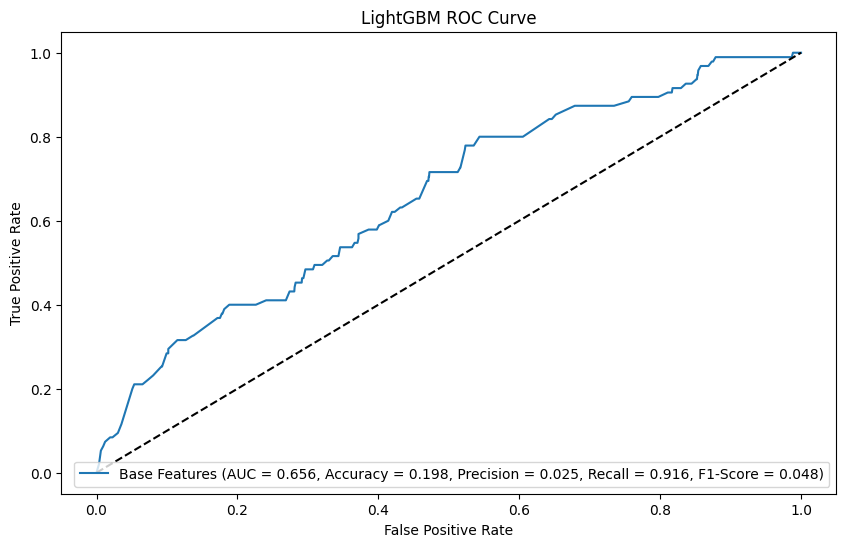

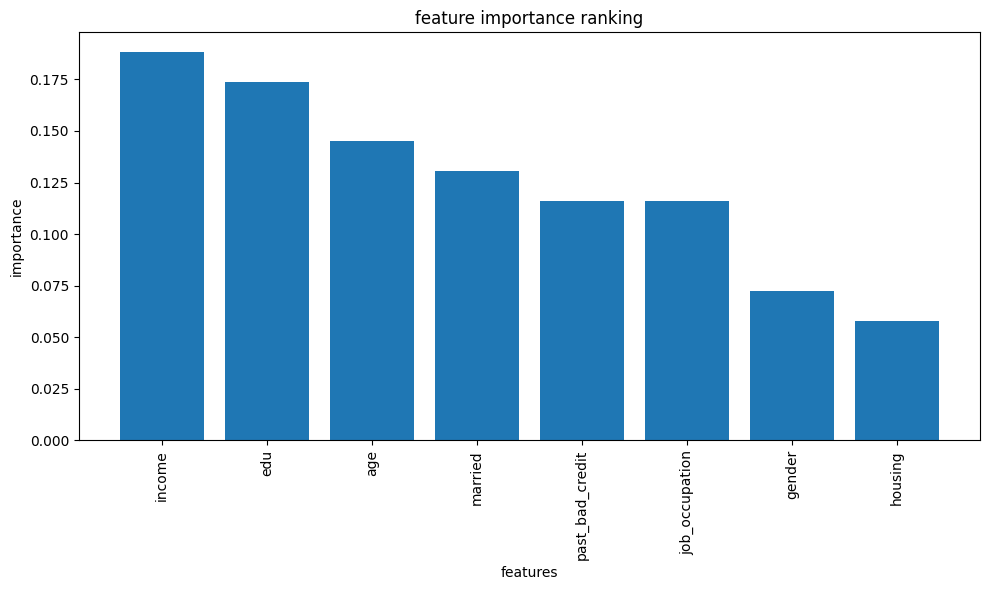

In [61]:
# Preprocessing for LightGBM

# Convert categorical features (LightGBM handles them natively)
cat_features = ['gender', 'edu', 'housing', 'job_occupation', 'past_bad_credit', 'married']
credit_risk_for_gbm_df = credit_risk_df.copy()
credit_risk_for_gbm_df[cat_features] = credit_risk_for_gbm_df[cat_features].astype('category')

auc_gbm, best_gbm = run_lightgbm(
    credit_risk_for_gbm_df.drop("default_label", axis=1),
    credit_risk_for_gbm_df["default_label"],
    model_name="Base Features"
)

In [58]:
# pretty print best_gbm model parameters
params = best_gbm.get_params()
params_df = pd.DataFrame(list(params.items()), columns=["Parameter", "Value"])

print(tabulate(
    params_df,
    headers="keys",
    tablefmt="grid",
    showindex=False
))

+-----------------------+----------+
| Parameter             | Value    |
+=======================+==========+
| boosting_type         | gbdt     |
+-----------------------+----------+
| class_weight          | balanced |
+-----------------------+----------+
| colsample_bytree      | 1.0      |
+-----------------------+----------+
| importance_type       | split    |
+-----------------------+----------+
| learning_rate         | 0.05     |
+-----------------------+----------+
| max_depth             | 3        |
+-----------------------+----------+
| min_child_samples     | 5        |
+-----------------------+----------+
| min_child_weight      | 0.001    |
+-----------------------+----------+
| min_split_gain        | 0.0      |
+-----------------------+----------+
| n_estimators          | 100      |
+-----------------------+----------+
| n_jobs                |          |
+-----------------------+----------+
| num_leaves            | 31       |
+-----------------------+----------+
|

In [35]:
# pretty print
# normalise feature_importance_gbm so that all elements sum to one
feature_importance_gbm = best_gbm.feature_importances_
feature_importance_gbm = feature_importance_gbm / feature_importance_gbm.sum()

sorted_idx = feature_importance_gbm.argsort()[::-1]
feature_importance_df = pd.DataFrame({
    "Feature": credit_risk_df.drop("default_label", axis=1).columns[sorted_idx],
    "Importance": feature_importance_gbm[sorted_idx]
})

print(tabulate(
    feature_importance_df,
    headers="keys",
    tablefmt="grid",
    showindex=False
))

+-----------------+--------------+
| Feature         |   Importance |
+=================+==============+
| income          |    0.36646   |
+-----------------+--------------+
| age             |    0.259317  |
+-----------------+--------------+
| edu             |    0.136646  |
+-----------------+--------------+
| job_occupation  |    0.0729814 |
+-----------------+--------------+
| married         |    0.0543478 |
+-----------------+--------------+
| housing         |    0.0419255 |
+-----------------+--------------+
| past_bad_credit |    0.0357143 |
+-----------------+--------------+
| gender          |    0.0326087 |
+-----------------+--------------+


#### 2.1 Data Preprocessing

#### 2.2 Feature Importance Analysis

#### 2.3 Go Deeper towards Feature Importance Analysis! 